__Kaggle competition - Titanic survivorship__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Category feature EDA](#category-feature-EDA)
    1. [Count feature EDA](#Count-feature-EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
        1. [Encoding](#Encoding)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
    1. [Additional exploratory data analysis](#Additional-exploratory-data-analysis)
1. [Feature selection](#Feature-selection)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
    1. [Submission - standard models](#Submission-standard-models)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Submission - stacked models](#Submission-stacked-models)    

# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time
rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    IsolationForest,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    Lasso,
    Ridge,
    ElasticNet,
    LinearRegression,
    LogisticRegression,
    SGDRegressor,
)
from sklearn.model_selection import (
    KFold,
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    LabelEncoder,
    OneHotEncoder,
    KBinsDiscretizer,
    QuantileTransformer,
    PowerTransformer,
    MinMaxScaler,
)
from sklearn.svm import SVC, SVR
from category_encoders import WOEEncoder, TargetEncoder, CatBoostEncoder, BinaryEncoder, CountEncoder

from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from hyperopt import hp
import shap

shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    from mlmachine.data import titanic
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasTransformer,
        KFoldSelectEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style

## Data

<a id = 'Data'></a>

In [2]:
# load data and print dimensions
df_train, df_valid = titanic()

print("Training data dimensions: {}".format(df_train.shape))
print("Validation data dimensions: {}".format(df_valid.shape))

Training data dimensions: (891, 12)
Validation data dimensions: (418, 11)


In [3]:
# display info and first 5 rows
df_train.info()
display(df_train[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,NaN,S


In [4]:
# review counts of different column types
df_train.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [5]:
# Load training data into mlmachine
ordinal_encodings = {
        "Pclass": [1, 2, 3], # Pclass
    }

train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
    is_classification=True,
)

>>> category label encoding

	0 --> 0
	1 --> 1



In [6]:
# load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
    is_classification=True,
)

# EDA

<a id = 'EDA'></a>

## Category feature EDA

<a id = 'category-feature-EDA'></a>

Feature summary Feature vs. target summary Target proportion 
 
 
 Embarked 
 Count 
 Proportion 
 
 
 
 
 S 
 644 
 72.440945 
 
 
 C 
 168 
 18.897638 
 
 
 Q 
 77 
 8.661417 
 
 
 
 
 
 Embarked 
 Died 
 Survived 
 
 
 
 
 C 
 75 
 93 
 
 
 Q 
 47 
 30 
 
 
 S 
 427 
 217 
 
 
 
 
 
 Class 
 C 
 Q 
 S 
 
 
 
 
 Died 
 44.642857 
 61.038961 
 66.304348 
 
 
 Survived 
 55.357143 
 38.961039 
 33.695652

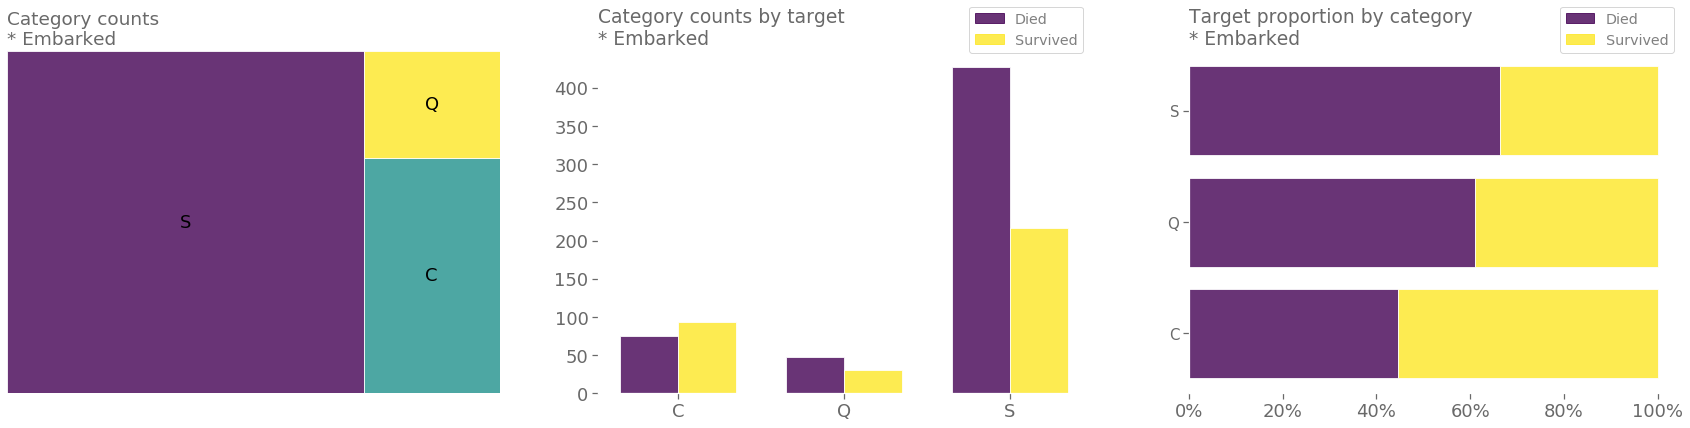

Feature summary Feature vs. target summary Target proportion Statistical test 
 
 
 Sex 
 Count 
 Proportion 
 
 
 
 
 male 
 577 
 64.758698 
 
 
 female 
 314 
 35.241302 
 
 
 
 
 
 Sex 
 Died 
 Survived 
 
 
 
 
 female 
 81 
 233 
 
 
 male 
 468 
 109 
 
 
 
 
 
 Class 
 female 
 male 
 
 
 
 
 Died 
 25.796178 
 81.109185 
 
 
 Survived 
 74.203822 
 18.890815 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 16.218800 
 0.000000

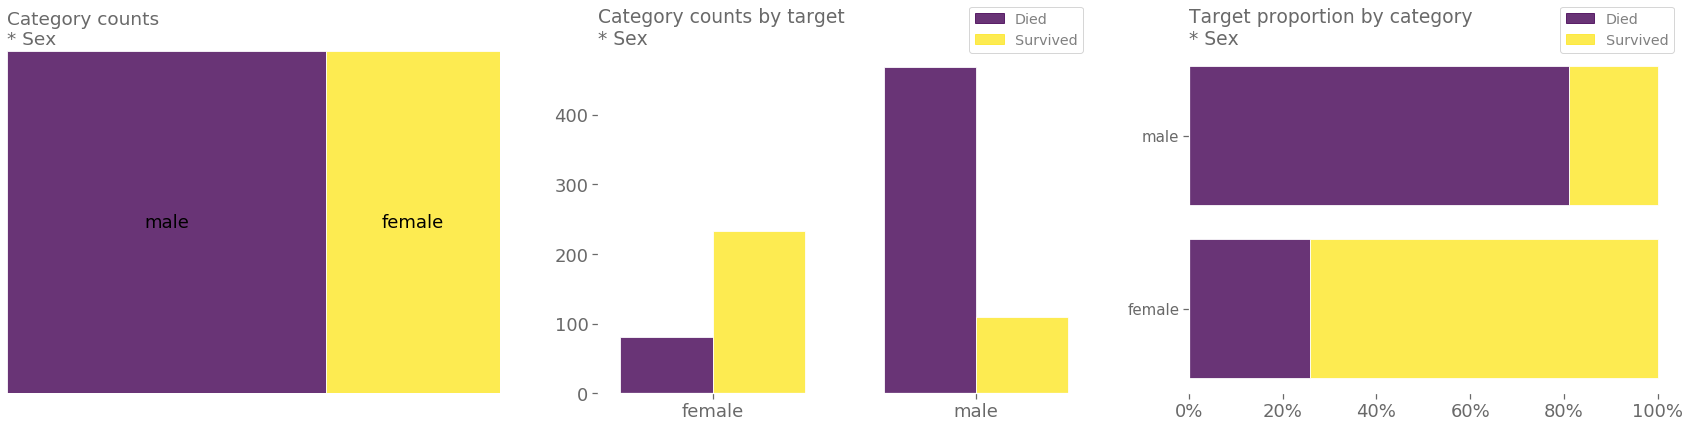

Feature summary Feature vs. target summary Target proportion 
 
 
 Pclass 
 Count 
 Proportion 
 
 
 
 
 3 
 491 
 55.106622 
 
 
 1 
 216 
 24.242424 
 
 
 2 
 184 
 20.650954 
 
 
 
 
 
 Pclass 
 Died 
 Survived 
 
 
 
 
 1 
 80 
 136 
 
 
 2 
 97 
 87 
 
 
 3 
 372 
 119 
 
 
 
 
 
 Class 
 1 
 2 
 3 
 
 
 
 
 Died 
 37.037037 
 52.717391 
 75.763747 
 
 
 Survived 
 62.962963 
 47.282609 
 24.236253

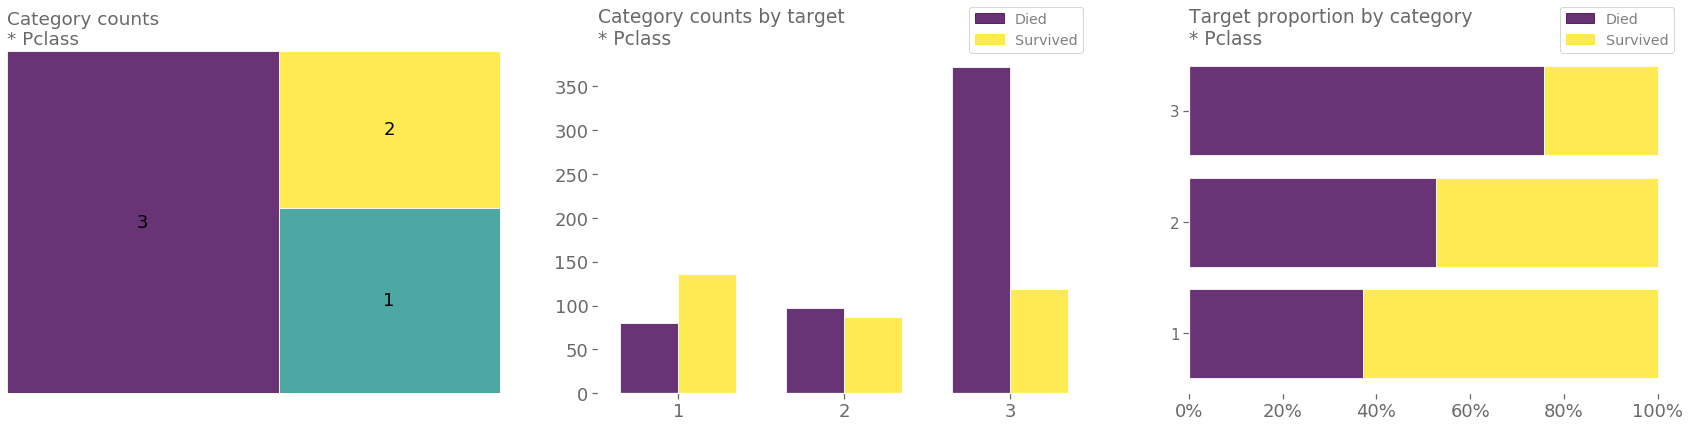

In [7]:
# category features
for feature in train.data.mlm_dtypes["category"]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=10,
        legend_labels=["Died","Survived"],
        chart_scale=15
    )

## Count feature EDA

<a id = 'Count-feature-EDA'></a>

Feature summary,Feature vs. target summary,Target proportion
Parch,Count,Proportion
0,678,76.094276
1,118,13.243547
2,80,8.978676
3,5,0.561167
5,5,0.561167
4,4,0.448934
6,1,0.112233
Parch,Died,Survived
0,445,233


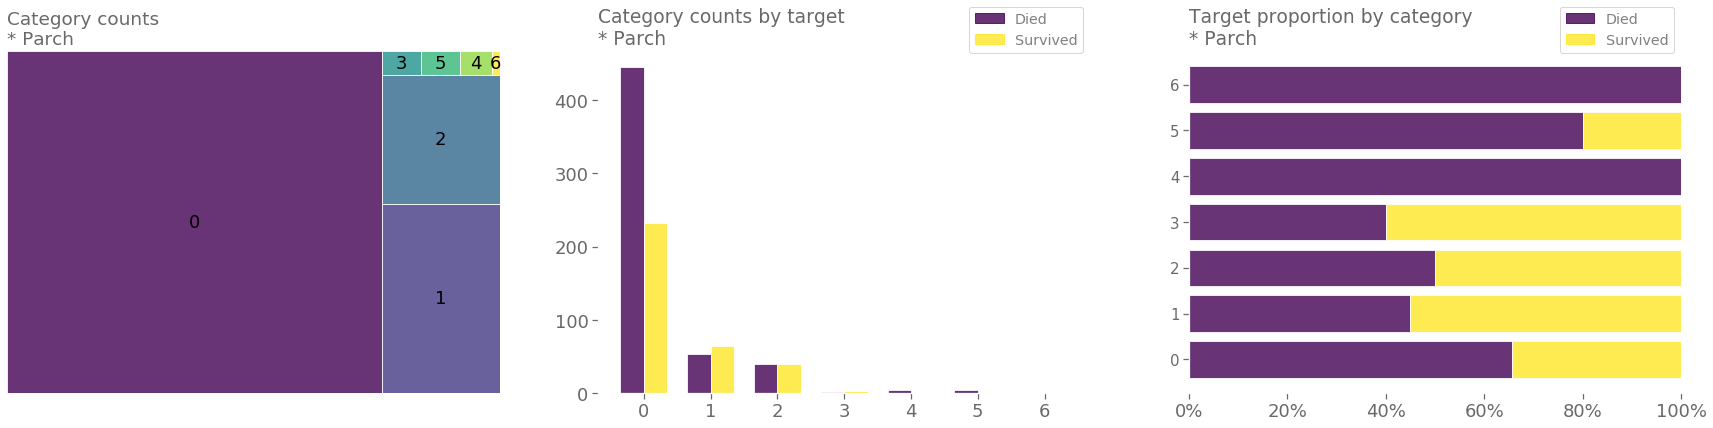

Feature summary,Feature vs. target summary,Target proportion
SibSp,Count,Proportion
0,608,68.237935
1,209,23.456790
2,28,3.142536
4,18,2.020202
3,16,1.795735
8,7,0.785634
5,5,0.561167
SibSp,Died,Survived
0,398,210


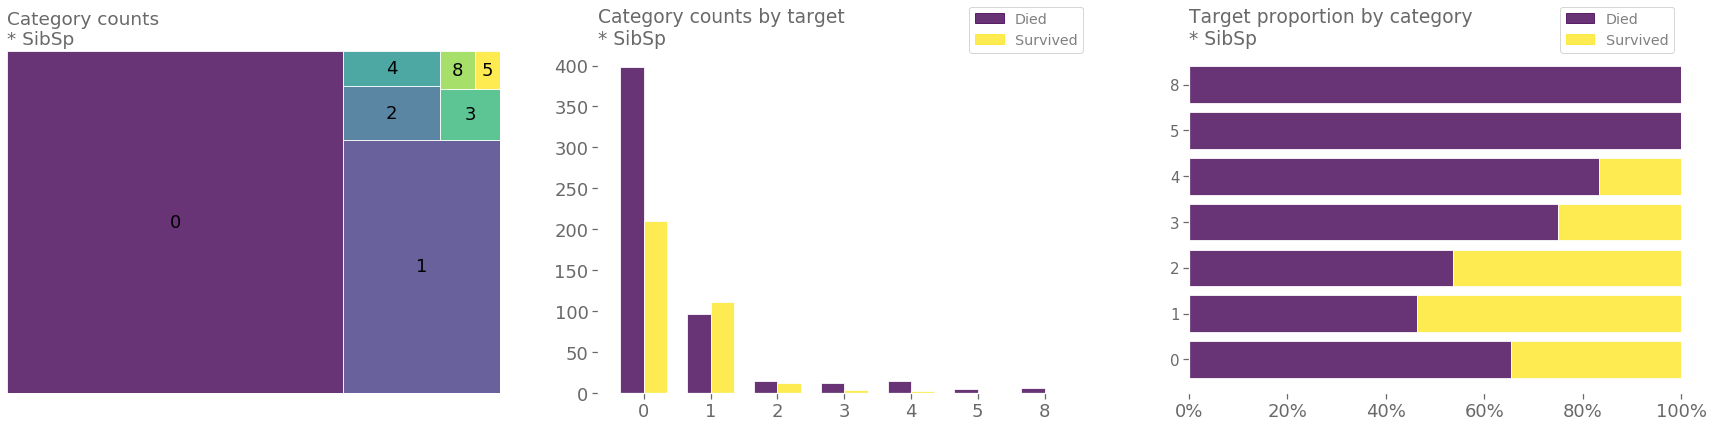

In [8]:
# number features
for feature in train.data.mlm_dtypes["count"]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=10,
        legend_labels=["Died","Survived"],
        chart_scale=15
    )

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Age 
 
 
 
 
 count 
 714.000000 
 
 
 mean 
 29.699118 
 
 
 std 
 14.526497 
 
 
 min 
 0.420000 
 
 
 25% 
 20.125000 
 
 
 50% 
 28.000000 
 
 
 75% 
 38.000000 
 
 
 max 
 80.000000 
 
 
 missing 
 177.000000 
 
 
 skew 
 0.388290 
 
 
 kurtosis 
 0.168637 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Died 
 424.000000 
 59.383754 
 30.626179 
 14.155388 
 
 
 Survived 
 290.000000 
 40.616246 
 28.343690 
 14.925152 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 2.066700 
 0.038800

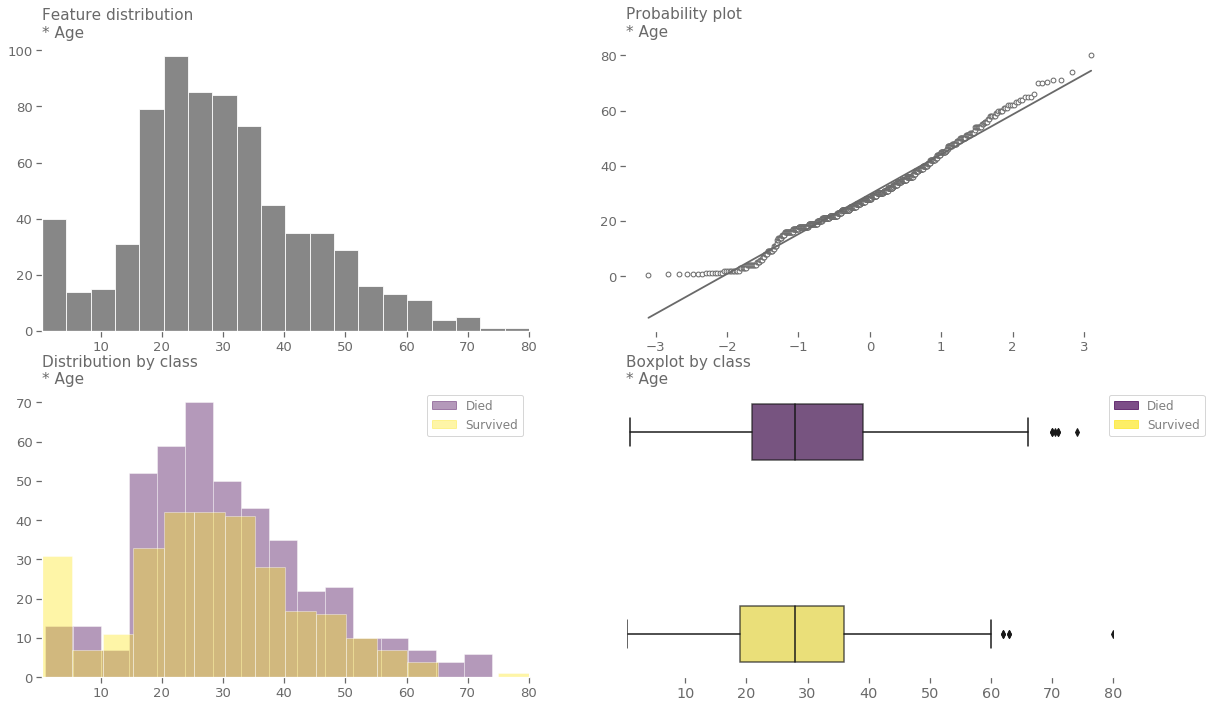

Feature summary Feature vs. target summary Statistical test 
 
 
 
 Fare 
 
 
 
 
 count 
 891.000000 
 
 
 mean 
 32.204208 
 
 
 std 
 49.693429 
 
 
 min 
 0.000000 
 
 
 25% 
 7.910400 
 
 
 50% 
 14.454200 
 
 
 75% 
 31.000000 
 
 
 max 
 512.329200 
 
 
 missing 
 0.000000 
 
 
 skew 
 4.779250 
 
 
 kurtosis 
 33.204289 
 
 
 
 
 
 Class 
 Count 
 Proportion 
 Mean 
 StdDev 
 
 
 
 
 Died 
 549.000000 
 61.616162 
 22.117887 
 31.359607 
 
 
 Survived 
 342.000000 
 38.383838 
 48.395408 
 66.499563 
 
 
 
 
 
 z_test statistic 
 p_value 
 
 
 
 
 -7.939200 
 0.000000

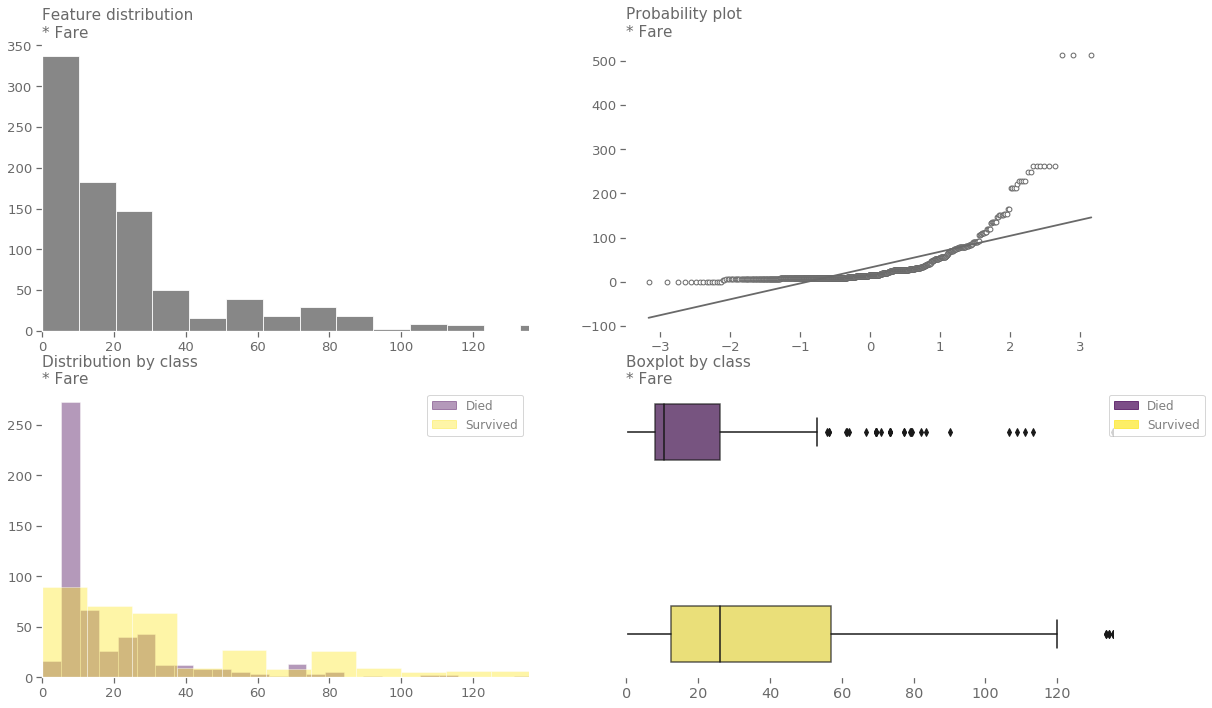

In [9]:
# continuous features
for feature in train.data.mlm_dtypes["continuous"]:
    train.eda_cat_target_num_feat(
        feature=feature,
        outliers_out_of_scope=5,
        legend_labels=["Died","Survived"],
        chart_scale=12
    )

##### Correlation

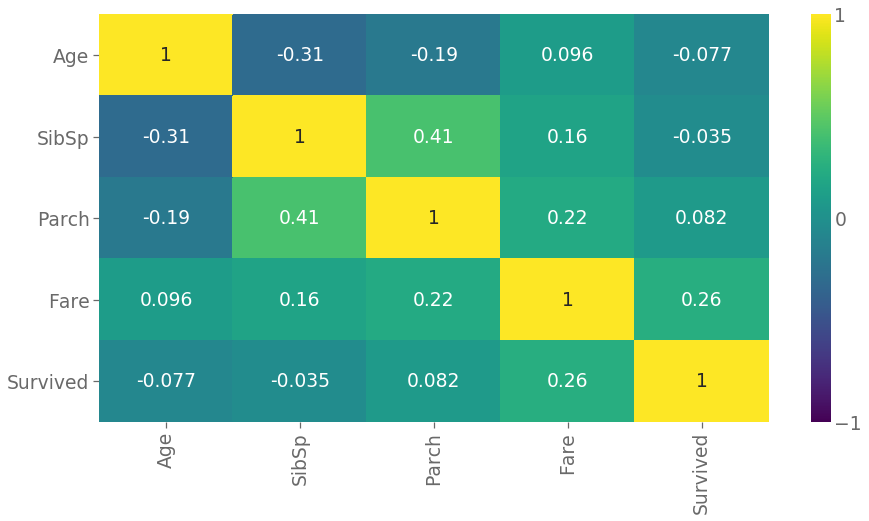

In [10]:
# correlation heat map
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=train.recombine_data(),
#     df=train.data,
    annot=True,
    ax=ax,
)

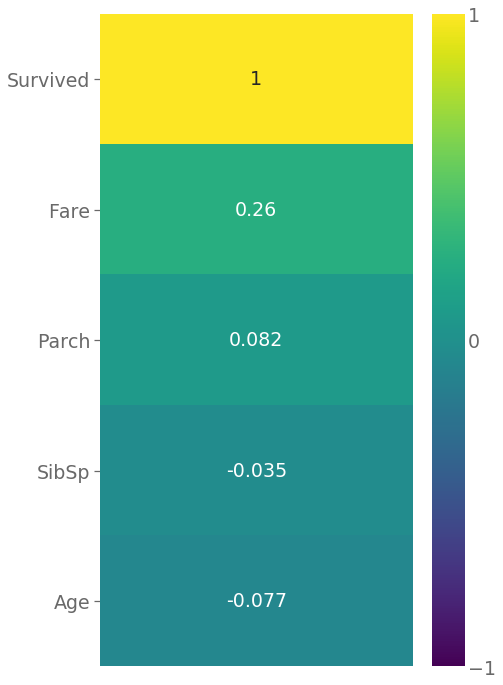

In [11]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=10)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.01,
    annot=True,
    ax=ax,
)

<Figure size 1080x540 with 0 Axes>

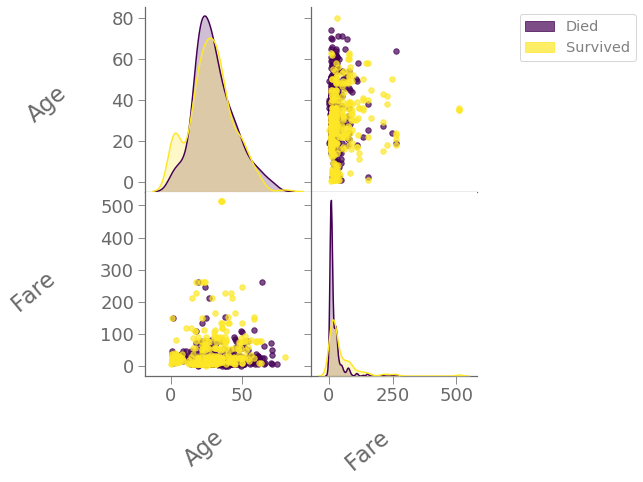

In [12]:
# pair plot
p = PrettierPlot(chart_scale=15)
p.pair_plot(
    df=train.data[["Age","Fare"]],
    target=train.target,
    diag_kind="auto",
    legend_labels=["Died","Survived"],
)

## Faceting

<a id = 'Faceting'></a>

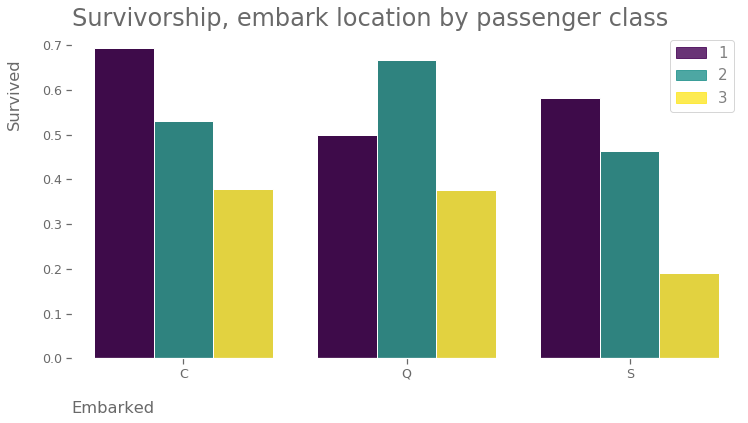

In [13]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Survivorship, embark location by passenger class", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    y_units="ff",
    ax=ax,
)

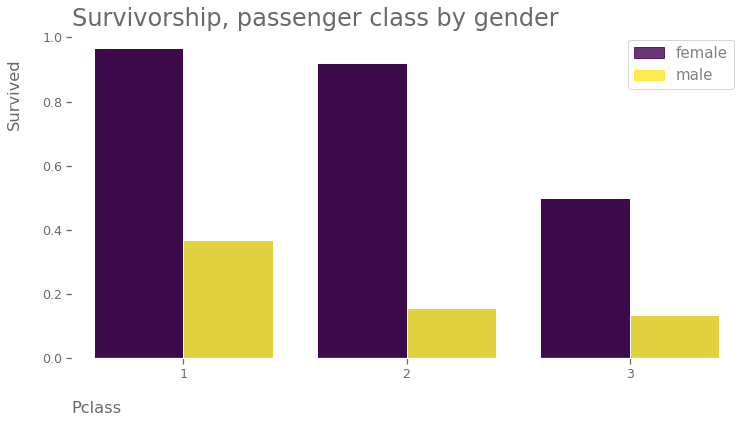

In [14]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Survivorship, passenger class by gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Pclass",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

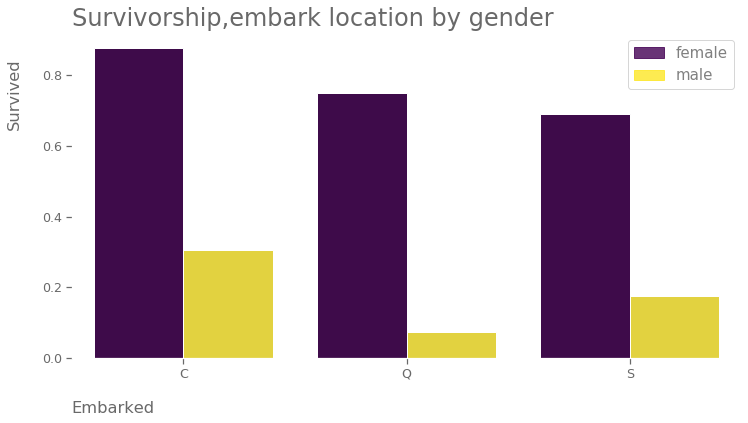

In [15]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Survivorship,embark location by gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

<Figure size 1080x540 with 0 Axes>

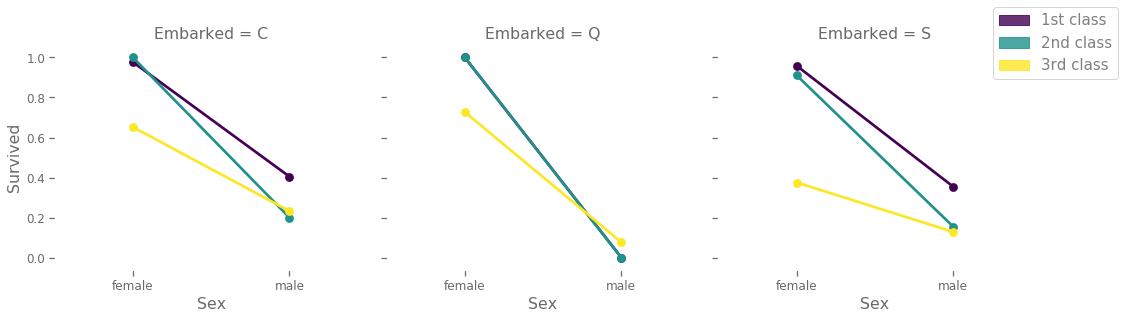

In [16]:
#
p = PrettierPlot()
p.facet_two_cat_point(
    df=train.recombine_data(train.data, train.target),
    x="Sex",
    y=train.target.name,
    split="Pclass",
    cat_col="Embarked",
    aspect=1.0,
    height=5,
    bbox=(1.3, 1.2),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

<Figure size 1080x540 with 0 Axes>

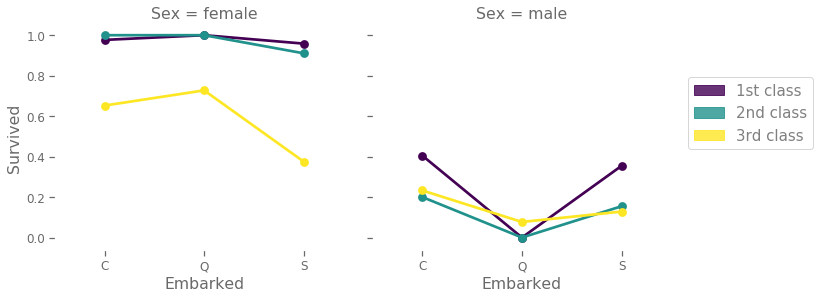

In [17]:
#
p = PrettierPlot()
p.facet_two_cat_point(
    df=train.recombine_data(train.data, train.target).dropna(subset=["Embarked"]),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    cat_col="Sex",
    aspect=1.0,
    height=5,
    bbox=(1.5, 0.8),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

<Figure size 1080x540 with 0 Axes>

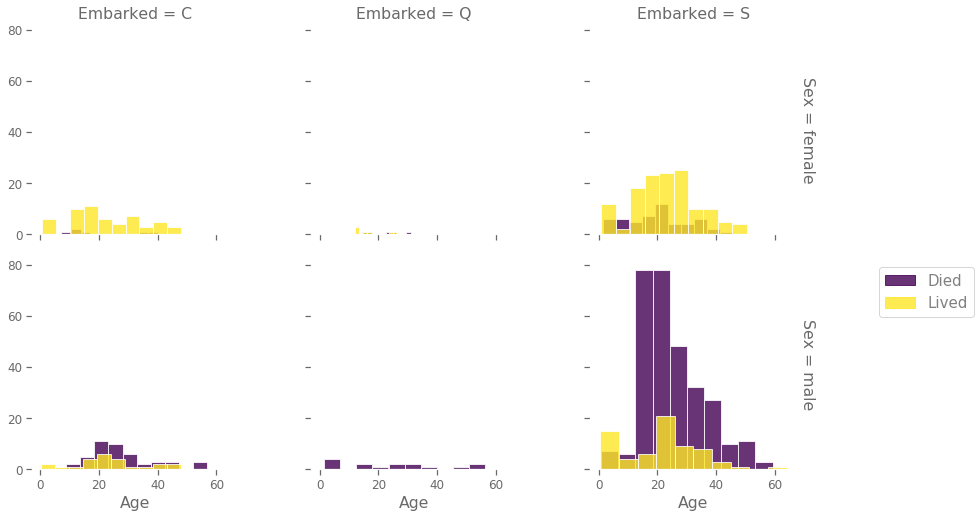

In [18]:
#
p = PrettierPlot()
p.facet_cat_num_hist(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    num_col="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

<Figure size 1080x540 with 0 Axes>

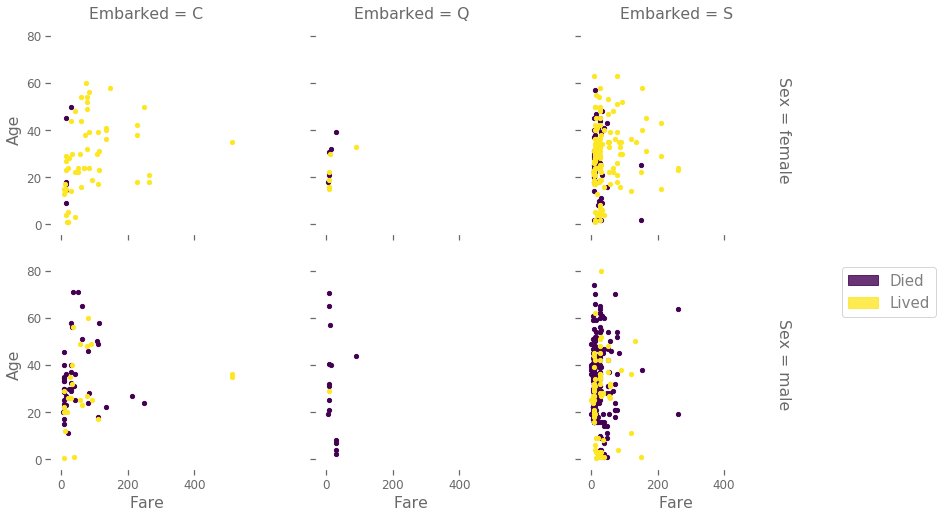

In [19]:
#
p = PrettierPlot(chart_scale=15)
p.facet_cat_num_scatter(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    x="Fare",
    y="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [20]:
# null score
pd.Series(train.target).value_counts(normalize=True)

0   0.616162
1   0.383838
Name: Survived, dtype: float64

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data


<a id = 'Missing-data'></a>

##### Training

,Total missing,Percent missing
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


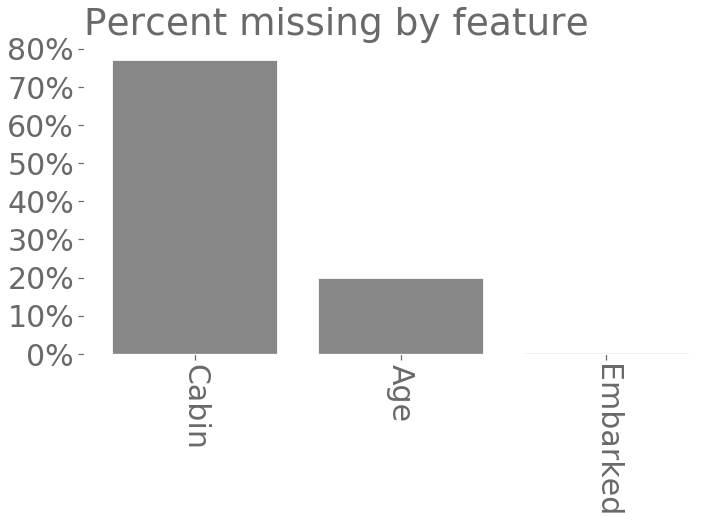

In [21]:
# evaluate missing data
train.eda_missing_summary()

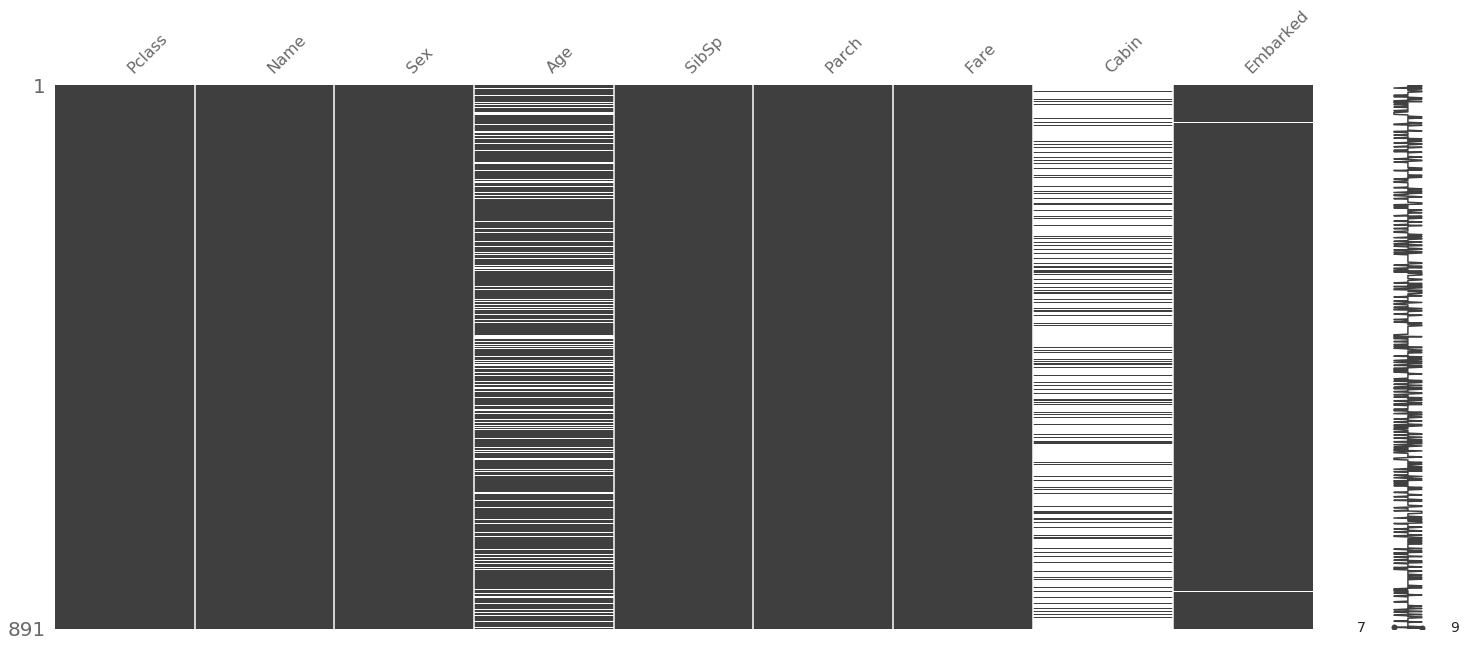

In [22]:
# missingno matrix
msno.matrix(train.data)

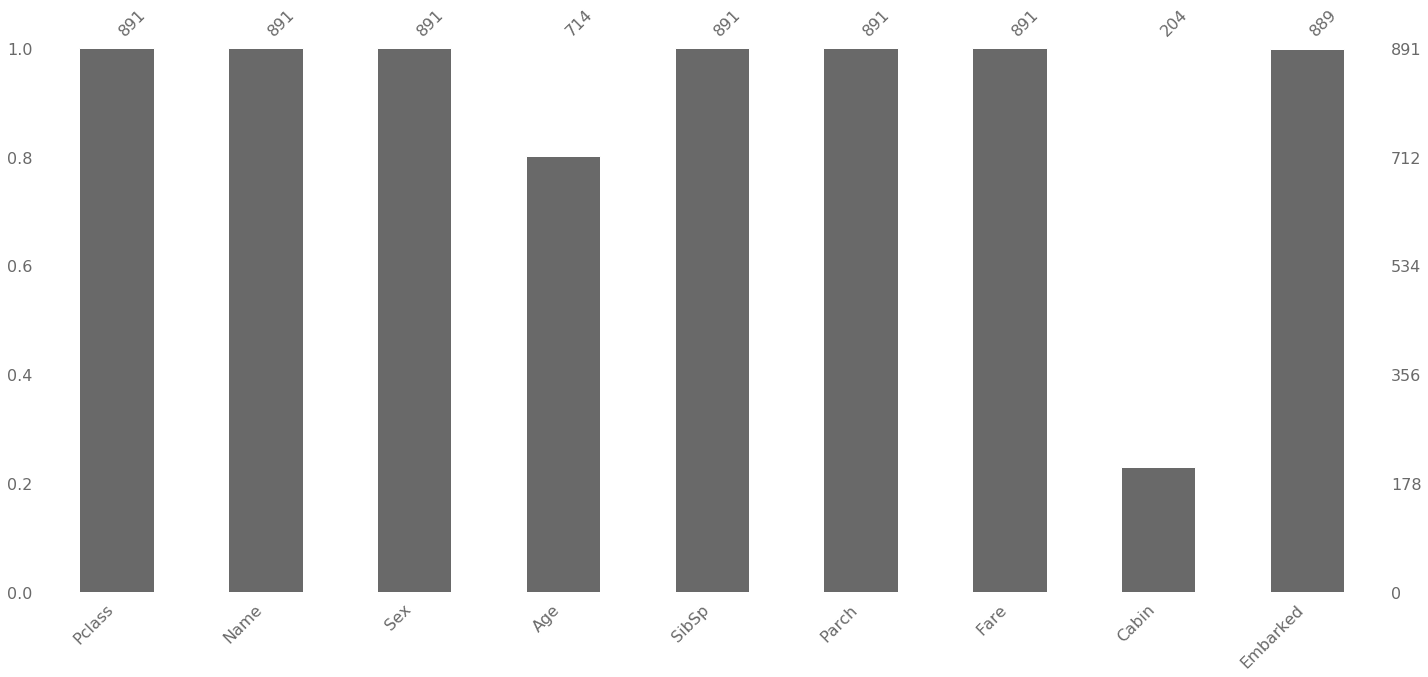

In [23]:
# missingno bar
msno.bar(train.data)

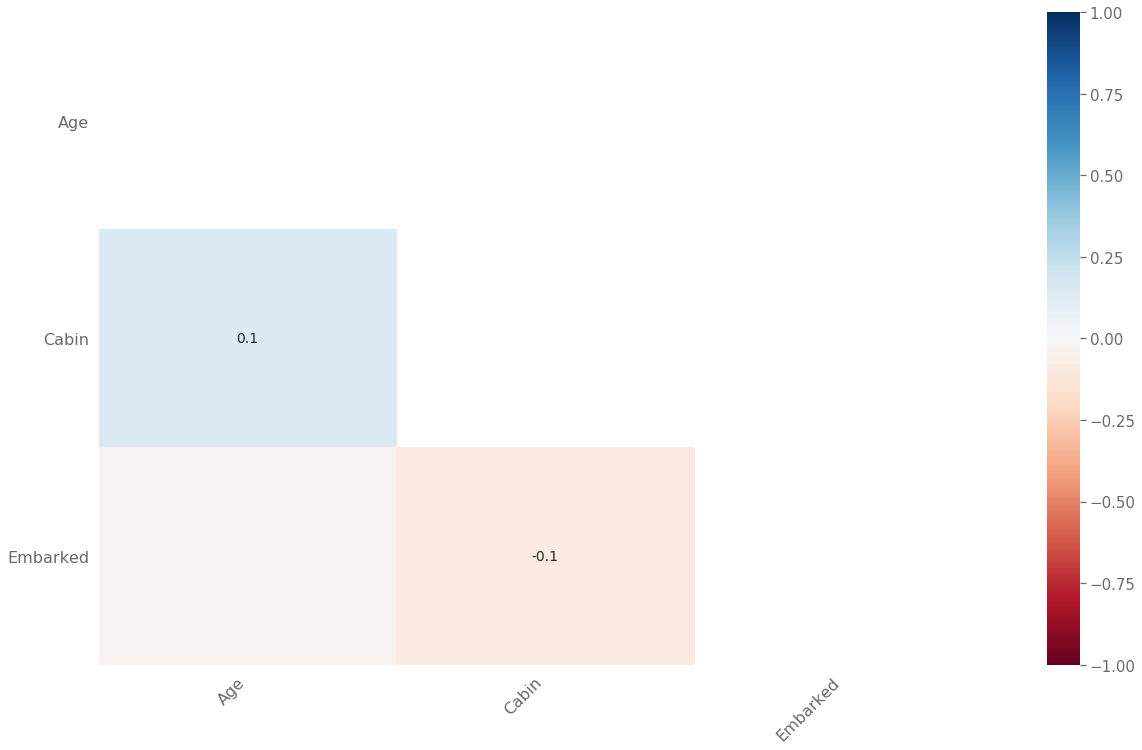

In [24]:
# missingno heatmap
msno.heatmap(train.data)

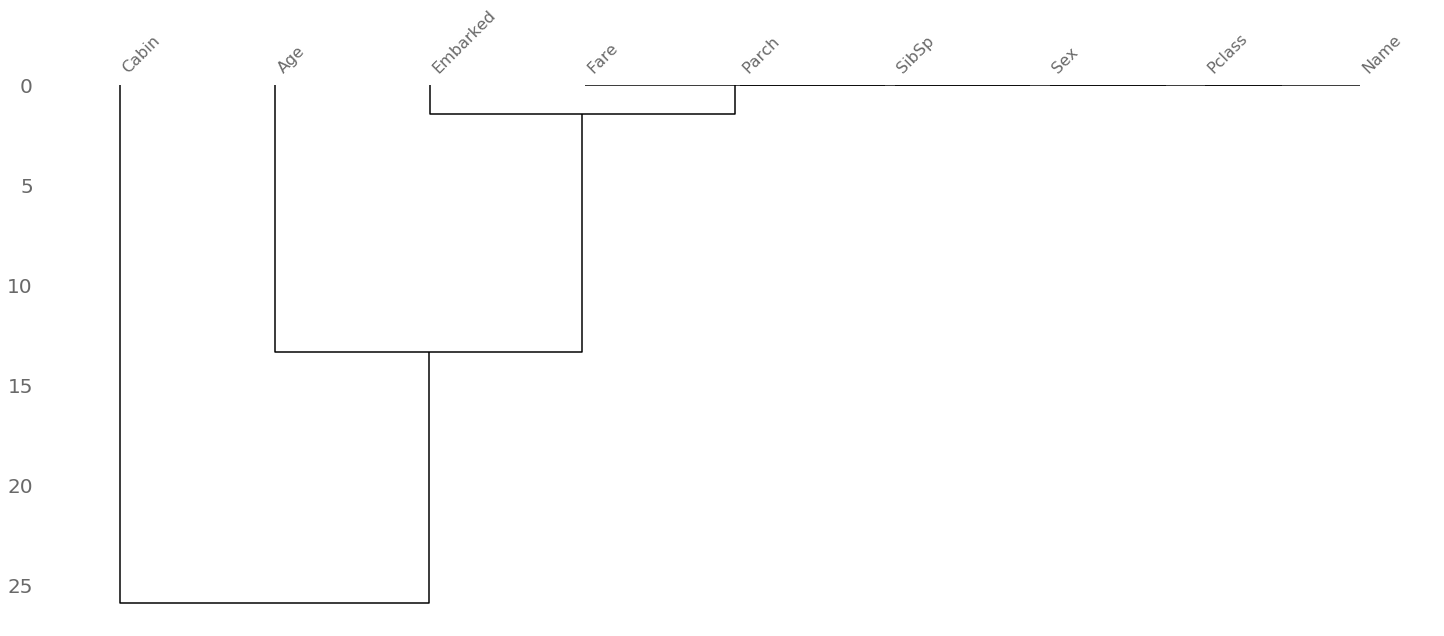

In [25]:
# missingno dendrogram
msno.dendrogram(train.data)

##### Validation

,Total missing,Percent missing
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


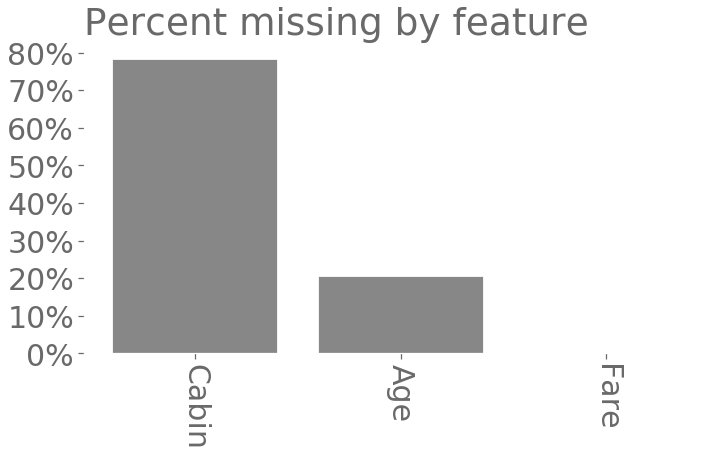

In [26]:
# evaluate missing data
valid.eda_missing_summary()

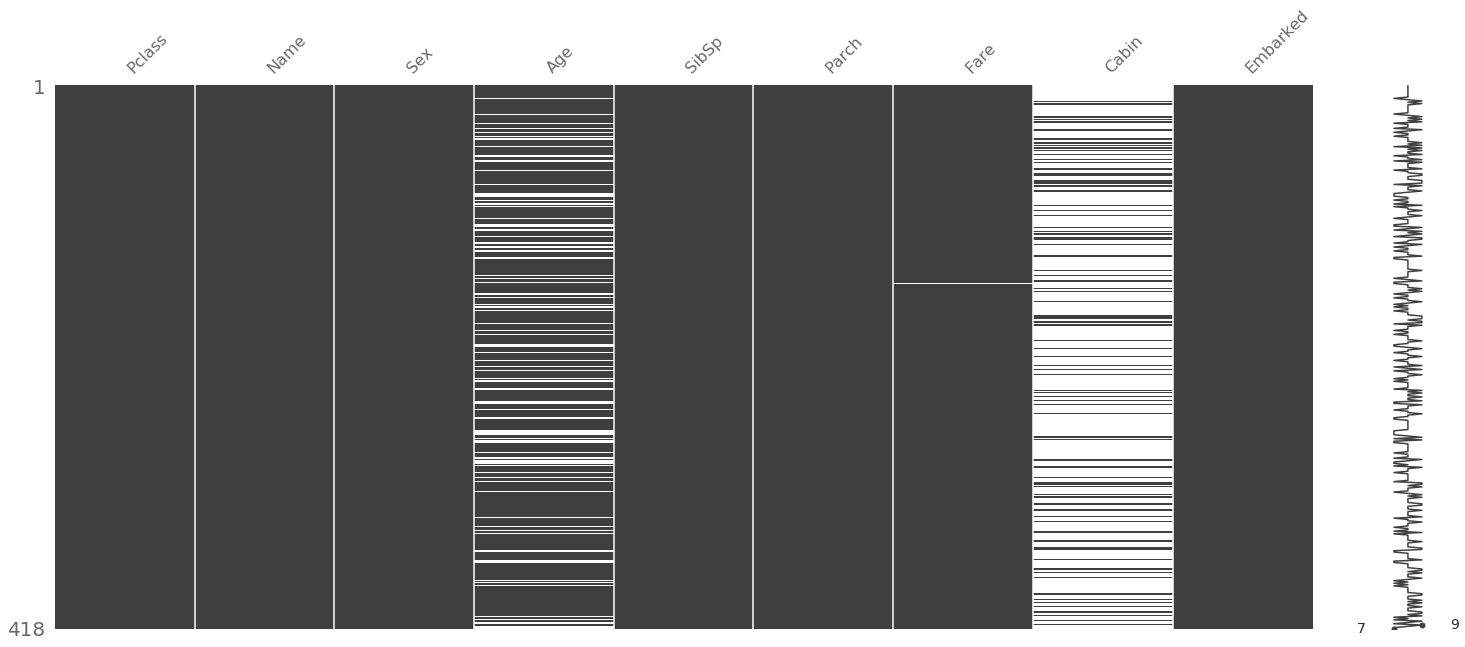

In [27]:
# missingno matrix
msno.matrix(valid.data)

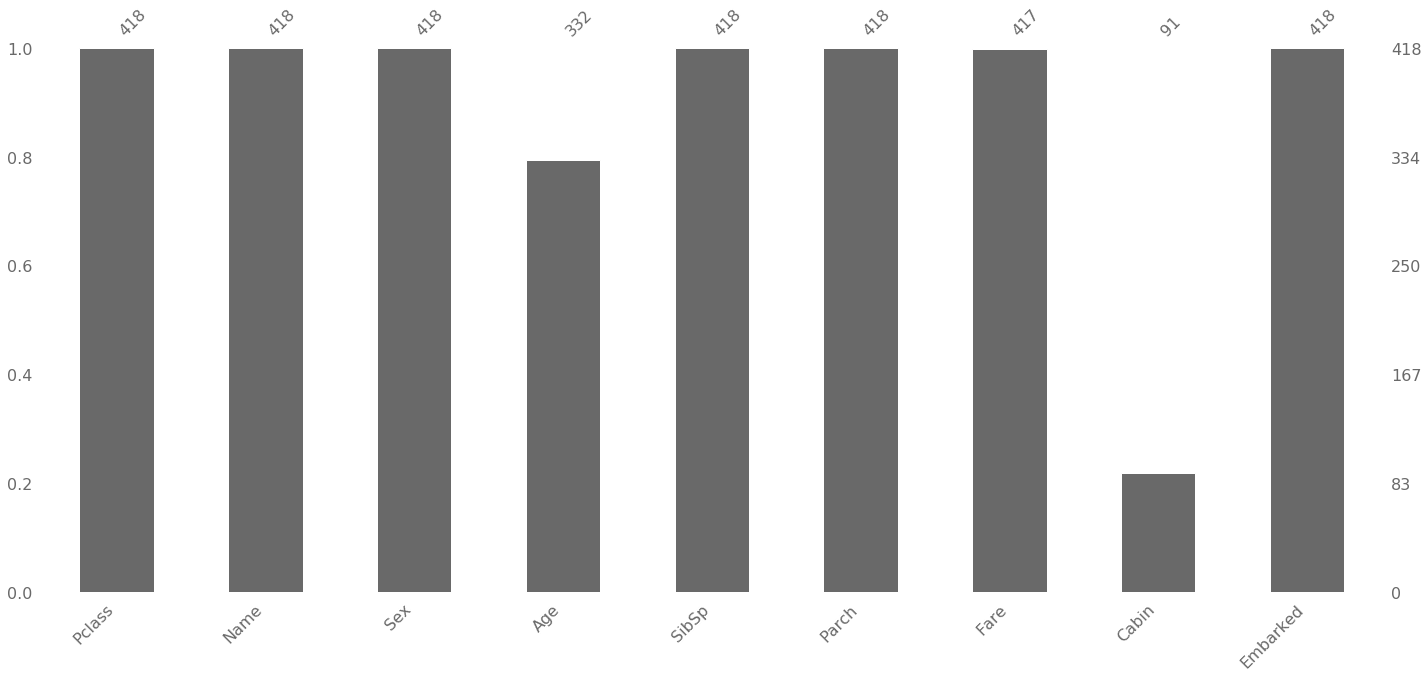

In [28]:
# missingno bar
msno.bar(valid.data)

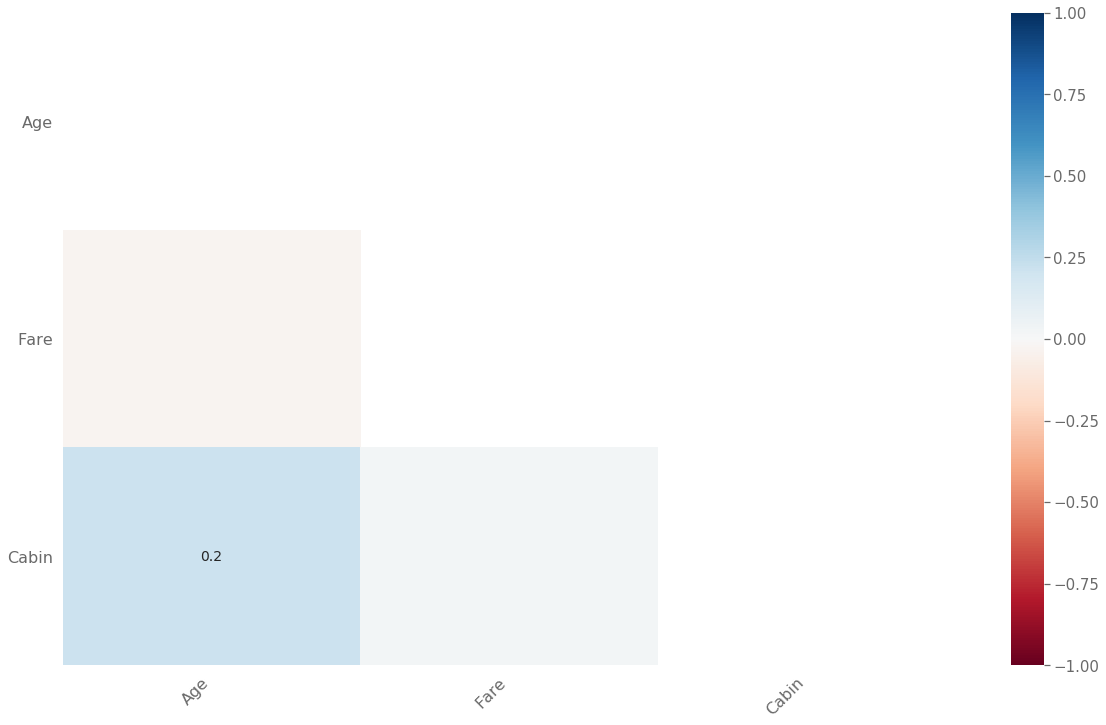

In [29]:
# missingno heatmap
msno.heatmap(valid.data)

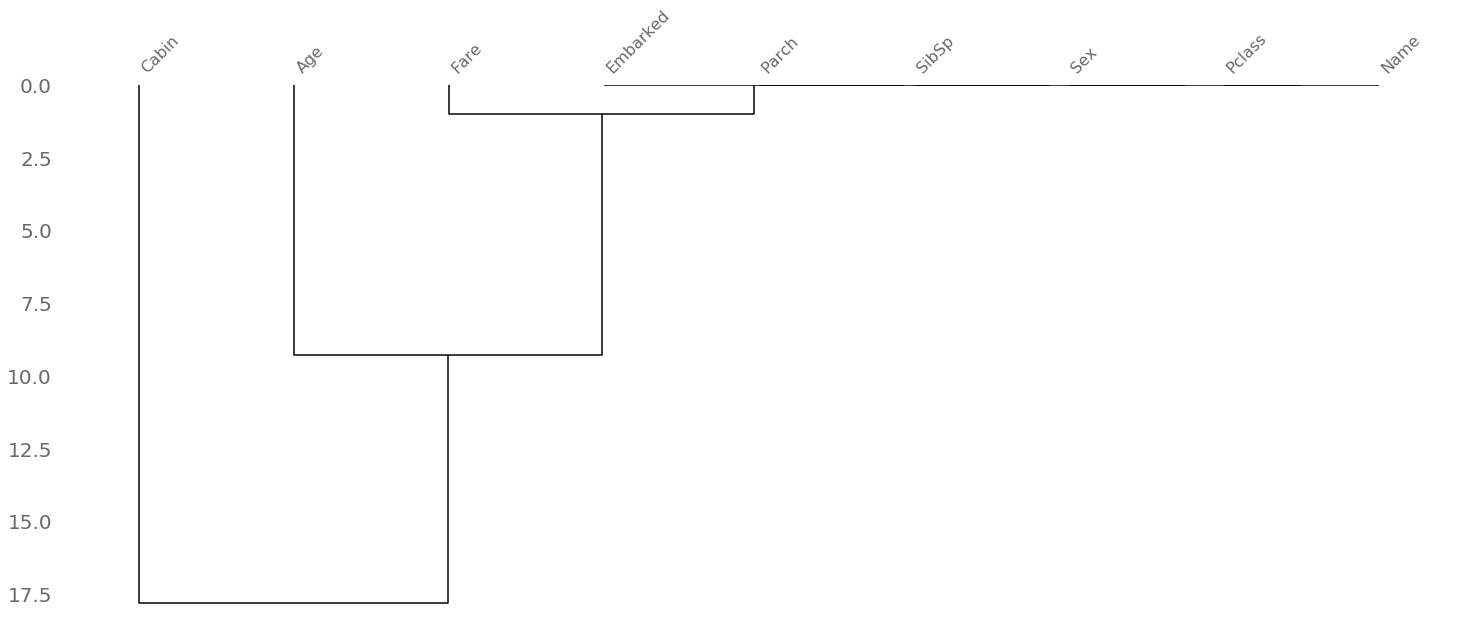

In [30]:
# missingno dendrogram
msno.dendrogram(valid.data)

##### Training vs. validation


In [31]:
# compare feature with missing data
train.missing_col_compare(train_data=train.data, validation_data=valid.data)

Feature has missing values in validation data, not training data.
{'Fare'}

Feature has missing values in training data, not validation data.
{'Embarked'}


##### Impute

In [32]:
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

In [33]:
train.eda_missing_summary()

No nulls


In [34]:
valid.eda_missing_summary()

No nulls


## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

In [35]:
### training data
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="object",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("category")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="category",
)

# family size features and binning
train.data["FamilySize"] = train.data["SibSp"] + train.data["Parch"] + 1
train.data["FamilySize"] = train.data["FamilySize"].astype("int64")

In [36]:
### validation data
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="object",
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("category")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="category",
)

# additional features
valid.data["FamilySize"] = valid.data["SibSp"] + valid.data["Parch"] + 1
valid.data["FamilySize"] = valid.data["FamilySize"].astype("int64")

### Polynomial features

<a id = 'Polynomial-features'></a>

In [37]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

### Encoding

<a id = 'Encoding'></a>

##### Evaluate

In [38]:
### training data
# counts of unique values in training data string columns
train.data[train.data.mlm_dtypes["category"]].apply(pd.Series.nunique, axis=0)

CabinQuarter    9
Embarked        3
Pclass          3
Sex             2
Title           4
dtype: int64

In [39]:
### train data
# print unique values in each category columns
train.unique_category_levels(data=train.data)

CabinQuarter 	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'X']
Embarked 	 ['C' 'Q' 'S']
Pclass 	 [1 2 3]
Sex 	 ['female' 'male']
Title 	 [0 1 2 3]


In [40]:
### validation data
# counts of unique values in validation data string columns
valid.data[valid.data.mlm_dtypes["category"]].apply(pd.Series.nunique, axis=0)

CabinQuarter    8
Embarked        3
Pclass          3
Sex             2
Title           4
dtype: int64

In [41]:
### validation data
# print unique values in each category columns
valid.unique_category_levels()

CabinQuarter 	 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'X']
Embarked 	 ['C' 'Q' 'S']
Pclass 	 [1 2 3]
Sex 	 ['female' 'male']
Title 	 [0 1 2 3]


In [42]:
# identify values that are present in the training data but not the validation data, and vice versa
train.compare_train_valid_levels(train_data=train.data, validation_data=valid.data)



*** CabinQuarter
Value present in training data, not in validation data
{'T'}
Value present in validation data, not in training data
set()


##### Encode

In [43]:
# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

In [44]:
# target encoding pipe
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Feature transformation

<a id = 'Feature-transformation'></a>

### Skew correction

<a id = 'Skew-correction'></a>

In [45]:
### training data
# evaluate skew of number features
train.skew_summary()

,skew,pct_zero
CabinQuarter_T_woe_encoded,-1.466226,0.000000
CabinQuarter_T_target_encoded,-0.149757,0.000000
CabinQuarter_T_catboost_encoded,-0.147981,0.000000
Embarked_Q_target_encoded,-0.082723,0.000000
Embarked_Q_catboost_encoded,-0.075186,0.000000
Fare^2_binned_5_woe_encoded,-0.064563,0.000000
Fare_binned_5_woe_encoded,-0.064563,0.000000
Age_binned_5_woe_encoded,0.045112,0.000000
Age^2_binned_5_woe_encoded,0.045112,0.000000
Fare^2_binned_5_target_encoded,0.093425,0.000000


In [46]:
### validation data
# evaluate skew of number features
valid.skew_summary()

,skew,pct_zero
CabinQuarter_T_catboost_encoded,-1.000000,0.000000
Fare^2_binned_5_woe_encoded,-0.078286,0.000000
Fare_binned_5_woe_encoded,-0.078286,0.000000
CabinQuarter_T_woe_encoded,0.000000,0.000000
Fare^2_binned_5_target_encoded,0.047042,0.000000
Fare_binned_5_target_encoded,0.047042,0.000000
Fare^2_binned_5_catboost_encoded,0.047269,0.000000
Fare_binned_5_catboost_encoded,0.047269,0.000000
Age*Fare_binned_5_woe_encoded,0.215353,0.000000
Pclass_ordinal_encoded_woe_encoded,0.334115,0.000000


In [47]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

# train.data = skew_pipe.fit_transform(train.data)
# valid.data = skew_pipe.transform(valid.data)

# train.update_dtypes()
# valid.update_dtypes()

### Scaling

<a id = 'Scaling'></a>

In [48]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", make_pipeline(
        DataFrameSelector(),
        PandasTransformer(RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Outliers


<a id = 'Outliers'></a>

In [49]:
# identify outliers using IQR
train_pipe = Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=10,
                iqr_step=1.5,
                features=train.data.mlm_dtypes["continuous"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(iqr_outliers)

[  1   6  27  52  54  62  88 124 195 215 218 224 230 245 252 257 262 268
 269 275 291 297 299 303 305 307 310 311 318 319 325 332 336 337 341 366
 390 393 412 438 496 520 587 591 659 716 730 737 741 742 745 759 763 765
 776 779 789 820 829 835 849 871 879]


In [50]:
# identify outliers using Isolation Forest
clf = IsolationForest(
    behaviour="new",
    max_samples=train.data.shape[0],
    random_state=0,
    contamination=0.01,
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

[ 75 128 159 205 245 251 263 303 776]


In [51]:
# identify outliers using extended isolation forest
train_pipe = Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.data.mlm_dtypes["continuous"],
                n_trees=100,
                sample_size=256,
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(eif_outliers)

[  1  27  31  52  54  61  66  75  88  97 102 118 124 128 148 151 177 205
 245 311 412 438 618 679 715 737 776]


In [52]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

[245 776]


In [53]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3]

,iqr,if,eif,count
245,x,x,x,3
776,x,x,x,3


In [54]:
# remove outlers from predictors and response
outliers = np.array([258, 305, 438, 679, 737, 745])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

## Additional exploratory data analysis

<a id = 'Additional-exploratory-data-analysis'></a>

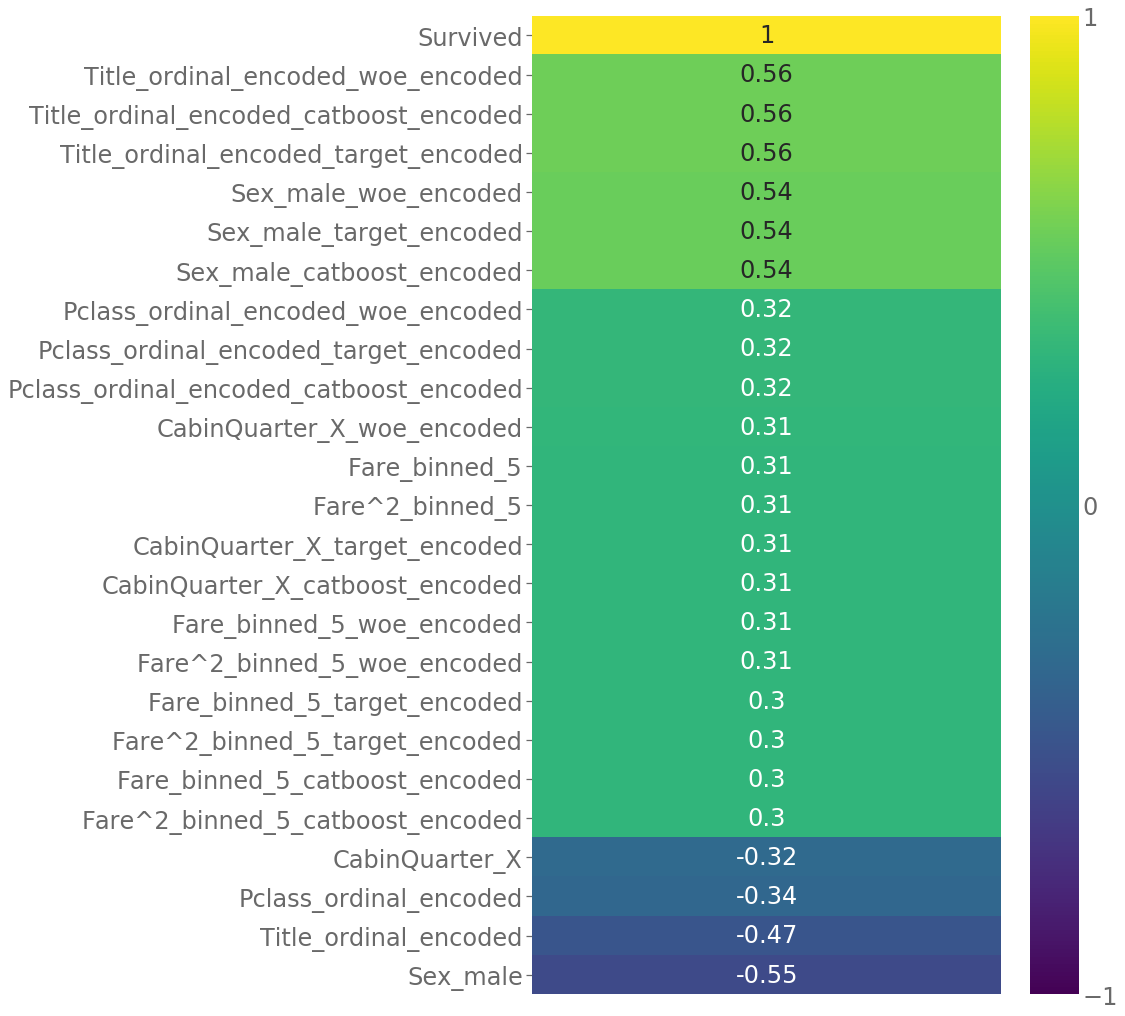

In [55]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=15)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.3,
    annot=True,
    ax=ax,
)

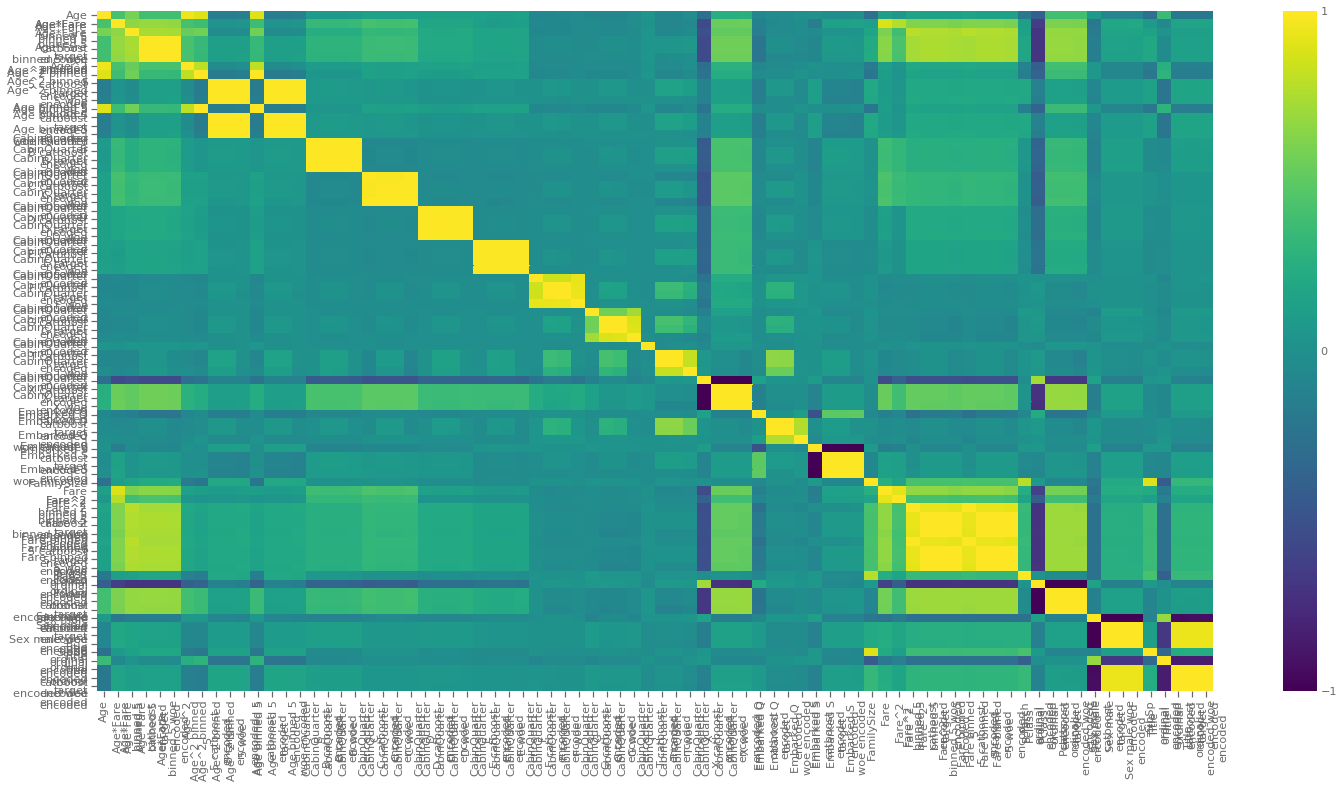

In [56]:
# correlation heat map
p = PrettierPlot(chart_scale=25)
ax = p.make_canvas()
p.corr_heatmap(df=train.data, annot=False, ax=ax)

# Feature selection

<a id = 'Feature-selection'></a>

In [ ]:
# generate feature importance summary
estimators = [
    LGBMClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data,
    target=train.target,
    estimators=estimators,
)
# feature_selector_summary = fs.feature_selector_suite(
#     save_to_csv=True,
#     n_jobs=5,
# )

In [ ]:
# calculate cross-validation performance
estimators = [
    SVC,
    LGBMClassifier,
    LogisticRegression,
    XGBClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    KNeighborsClassifier,
]

cv_summary = fs.feature_selector_cross_val(
#     feature_selector_summary=feature_selector_summary,
    feature_selector_summary = pd.read_csv("feature_selection_summary_2002030308.csv", index_col=0),
    estimators=estimators,
    scoring=["accuracy"],
    n_folds=5,
    step=1,
    n_jobs=15,
    save_to_csv=True,
)

###### Accuracy

In [ ]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
    scoring="accuracy",
#     cv_summary=cv_summary,
#     feature_selector_summary=feature_selector_summary,
    cv_summary= pd.read_csv("cv_summary_2002030350.csv", index_col=0),
    feature_selector_summary=pd.read_csv("feature_selection_summary_2002030308.csv", index_col=0),
    title_scale=0.8,
    marker_on=False,
)

In [ ]:
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="accuracy",
#     cv_summary=cv_summary,
#     feature_selector_summary=feature_selector_summary,
    cv_summary= pd.read_csv("cv_summary_2002020429.csv", index_col=0),
    feature_selector_summary=pd.read_csv("feature_selection_summary_2002020409.csv", index_col=0),
)

In [ ]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [ ]:
#################################################################################
# import training data
df_train, df_valid = titanic()

# Load training data into mlmachine
ordinal_encodings = {
        "Pclass": [1, 2, 3], # Pclass
    }

train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
    is_classification=True,
)

# import validation data
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
    is_classification=True,
)

#################################################################################
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasTransformer(SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasTransformer(SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

#################################################################################
# feature engineering - training

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="object",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("category")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="category",
)

# family size features
train.data["FamilySize"] = pd.to_numeric(train.data["SibSp"]) + pd.to_numeric(train.data["Parch"]) + 1

#################################################################################
# feature engineering - validation

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="object"
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("category")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="category",
)

# additional features
valid.data["FamilySize"] = pd.to_numeric(valid.data["SibSp"]) + pd.to_numeric(valid.data["Parch"]) + 1

train.update_dtypes()
valid.update_dtypes()

#################################################################################
### feature transformation pipeline
# polynomial feature pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasTransformer(PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# encode & bin pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["nominal"]),
        PandasTransformer(OneHotEncoder(drop="first")),
    )),
    ("ordinal", make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasTransformer(OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasTransformer(KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_columns=train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

###
# complex encoding
target_encode_pipe = PandasFeatureUnion([
    ("target", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=TargetEncoder,
        ),
    )),
    ("woe", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=WOEEncoder,
        ),
    )),
    ("catboost", make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=CatBoostEncoder,
        ),
    )),
    ("diff", make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

### scale features
scale_pipe = PandasFeatureUnion([
    ("scale", make_pipeline(
        DataFrameSelector(),
        PandasTransformer(RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

#################################################################################
# remove outliers
outliers = np.array([258, 305, 438, 679, 737, 745])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

print('completed')

## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [ ]:
# model/parameter space
all_space = {
    "LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.5),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
#     "LogisticRegression": {
#         "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
#         "penalty": hp.choice("penalty", ["l1", "l2"]),
#     },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "subsample": hp.uniform("subsample", 0.3, 1),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "algorithm": hp.choice("algorithm", ["SAMME", "SAMME.R"]),
    },
    "ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
    },
    "SVC": {
        "C": hp.uniform("C", 0.001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovo", "ovr"]),
        "gamma": hp.uniform("gamma", 0.000000001, 5),
    },
    "KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

# read scores summary table
bayes_optim_summary = pd.read_csv("bayes_optimization_summary_accuracy_2002030354.csv", na_values="nan")

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    columns=cross_val_feature_dict,
    scoring="accuracy",
    n_folds=5,
    n_jobs=5,
    iters=500,
    show_progressbar=True,
)

##### Model loss by iteration

In [ ]:
# read scores summary table
bayes_optim_summary = pd.read_csv("bayes_optimization_summary_accuracy_2002030354.csv", na_values="nan")

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator
    )

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_param_plot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
#         chart_scale=15,
        title_scale=1.2
    )

In [ ]:
# pair-wise comparison
p = PrettierPlot(chart_scale=12)
p.pair_plot_custom(
    df=train.unpack_bayes_optim_summary(bayes_optim_summary, "LGBMClassifier"),
    columns=["colsample_bytree", "learning_rate", "iteration","iter_loss"],
    gradient_col="iteration",
    color=style.style_grey
)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
train.classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    cm_labels=["Dies", "Survives"],
    n_folds=3,
)

In [ ]:
# classification panel, single model
estimator = 'LGBMClassifier'; model_iter = 21
# estimator = 'XGBClassifier'; model_iter = 148
# estimator = 'RandomForestClassifier'; model_iter = 493
# estimator = 'GradientBoostingClassifier'; model_iter = 402
# estimator = 'AdaBoostClassifier'; model_iter = 418
# estimator = 'ExtraTreesClassifier'; model_iter = 261
# estimator = 'SVC, model_iter = 263
# estimator = 'KNeighborsClassifier'; model_iter = 466

model = train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

X_train, X_valid, y_train, y_valid = train_test_split(train.data, train.target)

train.classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
#     X_train=X_train,
#     y_train=y_train,
#     X_valid=X_valid,
#     y_valid=y_valid,
    cm_labels=["Dies", "Survives"],
    n_folds=3,
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimClassifierBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=train.data, y_train=train.target, cm_labels=['Dies', 'Survives'], n_folds=4
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
estimator = 'LGBMClassifier'; model_iter = 21
# estimator = 'XGBClassifier'; model_iter = 148
# estimator = 'RandomForestClassifier'; model_iter = 493
# estimator = 'GradientBoostingClassifier'; model_iter = 402
# estimator = 'AdaBoostClassifier'; model_iter = 418
# estimator = 'ExtraTreesClassifier'; model_iter = 261
# estimator = 'SVC, model_iter = 263

# estimator = 'KNeighborsClassifier'; model_iter = 466

model = train.BayesOptimModelClassifier(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

model.fit(train.data.values, train.target.values)

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
train.single_shap_value_tree(obs_ix=[0], model=model, data=train.data)

In [ ]:
# SHAP force plots for individual observations
for i in train.data.index[:5]:
    train.single_shap_viz_tree(obs_ix=i, model=model, data=train.data, target=train.target)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = train.multi_shap_viz_tree(obs_ixs=train.data.index, model=model, data=train.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=train.data.index, model=model, data=train.data
)

In [ ]:
# SHAP dependence plot grid
# grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]
# grid_features = ['Age*Fare','Title_ordinal_encoded','Sex_male','Fare','Pclass_ordinal_encoded','CabinQuarter_X']
grid_features = ['Age*Fare','Title_ordinal_encoded','Fare','Pclass_ordinal_encoded','Sex_male']


train.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=train.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Fare",
    color_feature="Sex_male",
    feature_names=train.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Fare",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=train.data.columns,
    )

##### SHAP values - validation data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in valid.data.index[:2]:
    valid.single_shap_viz_tree(obsIx=i, model=model, data=valid.data)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = valid.multi_shap_viz_tree(obs_ixs=valid.data.index, model=model, data=valid.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = valid.multi_shap_value_tree(
    obs_ixs=valid.data.index, model=model, data=valid.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]

valid.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=valid.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

valid.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Age",
    color_feature="Parch",
    feature_names=valid.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = valid.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    valid.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
valid.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=valid.data.columns,
    )

## Submission - standard models

<a id = 'Submission-standard-models'></a>

In [ ]:
{'LGBMClassifier': [778],
 'LogisticRegression': [730],
 'XGBClassifier': [371],
 'RandomForestClassifier': [712],
 'GradientBoostingClassifier': [965],
 'AdaBoostClassifier': [512],
 'ExtraTreesClassifier': [244],
 'SVC': [551],
 'KNeighborsClassifier': [576]}

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "LGBMClassifier"; model_iter = 778  #147 survived, 0.775
# estimator = "XGBClassifier"; model_iter = 371  #142 survived, 0.765
# estimator = "RandomForestClassifier"; model_iter = 712  #144 survived, 0.7655
# estimator = "GradientBoostingClassifier"; model_iter = 965  #144 survived, 0.7561
estimator = "SVC"; model_iter = 551  # survived, 

# extract params and instantiate model
model = train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

# fit model and make predictions
y_pred = model.predict(valid.data.values)
print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": y_pred})
submit.to_csv("submission.csv", index=False)

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
{'LGBMClassifier': [778],
 'LogisticRegression': [730],
 'XGBClassifier': [371],
 'RandomForestClassifier': [712],
 'GradientBoostingClassifier': [965],
 'AdaBoostClassifier': [512],
 'ExtraTreesClassifier': [244],
 'SVC': [551],
 'KNeighborsClassifier': [576]}

In [ ]:
lgb = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="LGBMClassifier", model_iter=778)
lr = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="LogisticRegression", model_iter=730)
xgb = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="XGBClassifier", model_iter=371)
rf = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="RandomForestClassifier", model_iter=712)
gb = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="GradientBoostingClassifier", model_iter=965)
ada = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="AdaBoostClassifier", model_iter=512)
ext = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ExtraTreesClassifier", model_iter=244)
svc = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="SVC", model_iter=551)
kn = train.BayesOptimClassifierBuilder(bayes_optim_summary=bayes_optim_summary, estimator="KNeighborsClassifier", model_iter=576)

In [ ]:
from vecstack import StackingTransformer
from sklearn.metrics import accuracy_score
# Get your data

# Initialize 1st level estimators
estimators = [('lgb', lgb.model),
              ('lr',lr.model),
              ('xgb',xgb.model),
              ('rf',rf.model),
              ('gb',gb.model),
              ('ada',ada.model),
              ('ext',ext.model),
              ('svc',svc.model),
              ('kn',kn.model),
             ]
              
# Initialize StackingTransformer
stack = StackingTransformer(
    estimators,
    regression=False,
    metric=accuracy_score,
    verbose=2
)

# Fit
stack = stack.fit(train.data, train.target)

# Get your stacked features
oof_train = stack.transform(train.data)
oof_valid = stack.transform(valid.data)

# Use 2nd level estimator with stacked features

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)
plt.show()

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=oof_train,
    target=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=8,
    iters=1000,
    verbose=0,
)

In [ ]:
# read scores summary table
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_scale=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# classification panel, single model
estimator = "SVC"; model_iter = 135
# estimator = 'GradientBoostingClassifier'; model_iter = 590
# estimator = 'XGBClassifier'; model_iter = 380

model = train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimClassifierBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Submission - stacked models

<a id = 'Submission-stacked-models'></a>

In [ ]:
# best second level learning model
# estimator = "LGBMClassifier"; model_iter = 876 #0.75119
# estimator = "XGBClassifier"; model_iter = 821, #0.779
# estimator = "RandomForestClassifier"; model_iter = 82 
# estimator = "GradientBoostingClassifier"; model_iter = 673 #0.77511
estimator = "SVC"; model_iter = 538 # 0.77511

# extract params and instantiate model
model = train.BayesOptimClassifierBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

model.fit(oof_train, train.target.values)
y_pred = model.predict(oof_valid)
print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": y_pred})
submit.to_csv("submission.csv", index=False)